In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

# Set random seed
np.random.seed(0)

import h5py

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Load data
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
   
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))

##########################################
#data = np.load('data_with_labels.npz')
#train = data['arr_0']/255.
#labels = data['arr_1']

# Look at some data
print(train_set_x_orig[0])
print(train_set_y_orig[0])

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
[[[17 31 56]
  [22 33 59]
  [25 35 62]
  ...
  [ 1 28 57]
  [ 1 26 56]
  [ 1 22 51]]

 [[25 36 62]
  [28 38 64]
  [30 40 67]
  ...
  [ 1 27 56]
  [ 1 25 55]
  [ 2 21 51]]

 [[32 40 67]
  [34 42 69]
  [35 42 70]
  ...
  [ 1 25 55]
  [ 0 24 54]
  [ 1 21 51]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0

y = [1], it's a 'cat' picture.


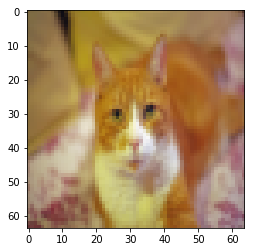

In [53]:
# Example of a picture
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

In [5]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

#standardize our dataset
#see lab 1 notes for more info
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [32]:
NOT Needed(from old template)

#convert to one hot
#def to_onehot(labels,nclasses = 5):
#    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[1., 0., 0., 0., 0, .0],
          [0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])
    '''
    outlabels = np.zeros((len(labels), nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [33]:
NOT Needed(from old template)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]

test, train = train[test_idx,:], train[training_idx, :]
onehot_test, onehot_train = onehot[test_idx, :], onehot[training_idx, :]

In [6]:
sess = tf.InteractiveSession()

In [13]:
# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [12288, None])
## Known labels
y_ = tf.placeholder("float", [1, None])

# Variables
W = tf.Variable(tf.zeros([1, 12288]))
b = tf.Variable(tf.zeros([1]))

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
#y = tf.nn.softmax(tf.matmul(x,W) + b)
z = tf.add(tf.matmul(W, x),b)
A = tf.sigmoid(z)
print ("W is: " + str(W.shape))
print ("x is: " + str(x.shape))
print ("z is: " + str(z.shape))
#print ("y is: " + str(y.shape))
print(b)
#print (type(y))

### End model specification, begin training code.

W is: (1, 12288)
x is: (12288, ?)
z is: (1, ?)
<tf.Variable 'Variable_5:0' shape=(1,) dtype=float32_ref>


In [14]:
# Climb on cross-entropy (cost function, I think)
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y + 1e-50, labels = y_))
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y_)

# How we train (GradientDescent)
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)

# Define accuracy
#correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [15]:
# Actually train
epochs = 1000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs)):
    # Record summary data, and the accuracy
    #if i % 10 == 0:
        # Check accuracy on train set
        #A = accuracy.eval(feed_dict={
            #x: train_set_x.reshape([-1, 12288]),
        #    x: train_set_x,
        #    y_: train_set_y_orig
        #})
     #   train_acc[i//10] = A
        # And now the validation set
  #      A = accuracy.eval(feed_dict={
  #          #x: test.reshape([-1,1296]),
  #          x: test_set_x,
  #          y_: test_set_y_orig
  #      })
  #      test_acc[i//10] = A
                
        train_step.run(feed_dict={
        #x: train.reshape([-1,1296]),
        #x: train_set_x.reshape([-1,12288z]),
        x: train_set_x,
        y_: train_set_y_orig
    })

100%|██████████████████████████████████████| 1000/1000 [00:31<00:00, 31.30it/s]


In [67]:
Good but not used 
# Notice the accuracy flattens out
print(train_acc[-1])
print(test_acc[-1])

0.0
0.0


In [42]:
# Train accuracy
n = train_set_x.shape[0] # The number of input features
m = train_set_x.shape[1] # The number of training examples

pred_train = A.eval({x:train_set_x})
corr_train = np.sum(np.equal(pred_train>0.5,train_set_y_orig>0.5))
print("The train accuracy is: "+str(corr_train/m))
print (n)

The train accuracy is: 1.0
12288


In [43]:
# Test accuracy
pred_test = A.eval({x:test_set_x})
#pred_test = A.eval({x:test_set_x, y_:test_set_y_orig})
corr_test = np.sum(np.equal(pred_test>0.5,test_set_y_orig>0.5))
print("The train accuracy is: "+str(corr_test/test_set_x.shape[1]))

The train accuracy is: 0.72


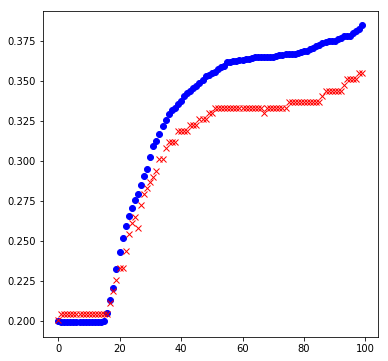

In [44]:
Good but not used 
# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc, 'bo')
plt.plot(test_acc, 'rx')

(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[  3.5309672   -8.641446    -3.9769633 ]
  [ -3.0386202  -16.250467    -9.022417  ]
  [ -0.3673849  -13.136126    -5.210544  ]
  ...
  [ 14.656187     4.5446353   14.101414  ]
  [ 13.124528     3.9737222   11.733743  ]
  [  7.91796      0.10020415   6.5183716 ]]

 [[  2.039245    -9.36337     -3.3474412 ]
  [ -0.17723893 -12.2285385   -4.4690924 ]
  [  3.723352    -7.535352     1.0367062 ]
  ...
  [ 12.640819     2.406647    11.656379  ]
  [ 11.904096     2.766294    11.449834  ]
  [  6.910088    -0.85647595   7.4687977 ]]

 [[  2.8187156   -8.983521    -4.2789793 ]
  [  1.7802492   -7.9544044   -3.73191   ]
  [  5.6998343   -4.5181108    0.92514265]
  ...
  [ 10.274421     0.56948483  10.52      ]
  [  9.934702     1.5400146    8.720606  ]
  [  8.334351     0.9327677    8.0817995 ]]

 ...

 [[  6.747224     2.6072412    7.1683235 ]
  [  1.2326423   -2.9119995    2.668529  ]
  [  2.090692    -4.292608     1.8401157 ]
  ...
  [  2.9035442   -4.271138     8.189004  ]
  [  0.72499496  -

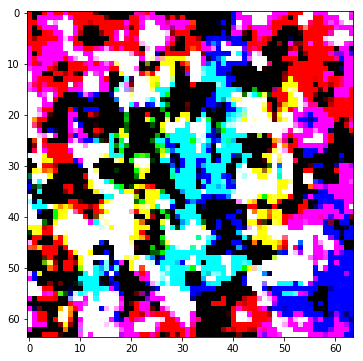

In [76]:
# Look at a subplot of the weights
plt.figure(figsize=(6,6))
#f, plts = plt.subplots(1, sharex=True)
#plts[1].pcolor(W.eval()[:,1].reshape([64,64]))

w_image_flat = W.eval()
w_image = w_image_flat.reshape(64,64,-1)
print (w_image.shape)
cc = plt.imshow(w_image)
print (w_image)

#plt.plot(w_image)

#for i in range(1):
#    plts[i].pcolor(W.eval()[:,i].reshape([64,64]))

In [55]:
W.eval()

array([[ 3.5309672, -8.641446 , -3.9769633, ..., -3.2973754, -9.124949 ,
         8.246825 ]], dtype=float32)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


The Algo says [[0.]]
<tf.Variable 'Variable_4:0' shape=(1, 12288) dtype=float32_ref>


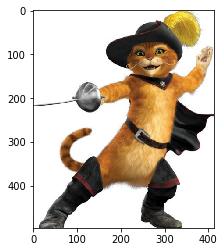

In [52]:
#test stuff
import scipy
from PIL import Image
from scipy import ndimage

fname = "datasets/puss.JPG"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T

print ("The Algo says " + str(A.eval({x:my_image})))
plt.imshow(image)
print (W)

In [29]:
print (my_image)
my_image255 = my_image/255

print (my_image255)

[[192]
 [196]
 [200]
 ...
 [245]
 [249]
 [252]]
[[0.75294118]
 [0.76862745]
 [0.78431373]
 ...
 [0.96078431]
 [0.97647059]
 [0.98823529]]


In [51]:
print ("W is: " + str(W.shape))
print(sess.run(W))

W is: (1, 12288)
[[ 3.5309672 -8.641446  -3.9769633 ... -3.2973754 -9.124949   8.246825 ]]
